In [ ]:
MODEL_NAME = "RLNet_MovieLens"
LEARNING_TYPE = "pairwise"

WORK_DIR_PATH = "../.."

# from google.colab import drive
# drive.mount('/content/drive')
# WORK_DIR_PATH = "/content/drive/MyDrive/RS-DeepCF/"

# Constants

In [ ]:
# split
EVAL_NEG_PER_POS = 99
TRN_BATCH_SIZE = 128
EVAL_BATCH_SIZE = 100
DATA_LOADING_TYPE = "general"
FILTER_BY = "user"
TRN_VAL_TST_RATIO = [0.8, 0.1, 0.1]
BATCH_SIZE = [TRN_BATCH_SIZE, TRN_BATCH_SIZE, EVAL_BATCH_SIZE, EVAL_BATCH_SIZE]
MAX_HIST = None
SHUFFLE = True

# Model
N_FACTORS = 32
HIDDEN_RL = [N_FACTORS*4, N_FACTORS*2, N_FACTORS, N_FACTORS // 2]
HIDDEN_ML = [N_FACTORS*2, N_FACTORS*2, N_FACTORS, N_FACTORS // 2]
DROPOUT = 0.2

# how to learn
LEARNING_RATE = 1e-4
LAMBDA_ = 1e-2

# how to monitor
PATIENCE = 10
MIN_DELTA = 1e-3

# how to loop
N_EPOCHS = 1000
INTERVAL = 10

# Config

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir(WORK_DIR_PATH)
print(f"DIRECTORY: {os.getcwd()}")

DIRECTORY: c:\Users\jayar\Desktop\바탕 화면\탱구의대학원탈출기\RS-DeepCF


In [ ]:
import pandas as pd
import torch
from DeepCF import deepcf
import UTILS
from LOOP.loop import TrainingLoop
from LOOP.monitor.predictor import predict
from LOOP.monitor.monitor import EarlyStoppingMonitor
from LOOP.metric.ranking import ndcg_at_k as metric_fn
from LOOP.metric.ranking import top_k_loop

In [ ]:
if LEARNING_TYPE=="pairwise":
    TRN_NEG_PER_POS = 1
    NEG_PER_POS = [TRN_NEG_PER_POS, TRN_NEG_PER_POS, EVAL_NEG_PER_POS, EVAL_NEG_PER_POS]
    from DATA_SPLITTER.pairwise import trn_val_tst
    from LOOP.trainer.pairwise import PairwiseTrainer as Trainer
    from LOOP.loss_fn.bpr import bpr as task_fn

elif LEARNING_TYPE=="pointwise":
    TRN_NEG_PER_POS = 4
    NEG_PER_POS = [TRN_NEG_PER_POS, TRN_NEG_PER_POS, EVAL_NEG_PER_POS, EVAL_NEG_PER_POS]
    from DATA_SPLITTER.pointwise import trn_val_tst
    from LOOP.trainer.pointwise import PointwiseTrainer as Trainer
    from LOOP.loss_fn.bce import bce as task_fn

else:
    ValueError

In [ ]:
from UTILS.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_LABEL_COL,
    DEFAULT_TIMESTAMP_COL,
    DEFAULT_PREDICTION_COL,
    COL_DICT,
    DEFAULT_K,
    DEFAULT_THRESHOLD,
    SEED,
)

In [ ]:
# seed
UTILS.seed.reset()

SETTING ALL SEEDS TO 42...
ALL SEEDS SET


In [6]:
# Available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Preparation

In [ ]:
# Upload Data
DATA_NAME = "ml-100k.csv"
DATA_PATH = f"./_data/{DATA_NAME}"
data = pd.read_csv(DATA_PATH)

In [ ]:
# Columns
kwargs = dict(
    col_user='userId', 
    col_item='movieId', 
    col_rating='rating',
    col_timestamp='timestamp'
)

data = UTILS.data_handler.rename_columns(data, **kwargs)

In [ ]:
# Label encoding
kwargs = dict(
    data=data,
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
)

data, user_label, item_label = UTILS.data_handler.label_encoding(**kwargs)

In [ ]:
# Number of user, item
N_USERS = data[DEFAULT_USER_COL].nunique()
N_ITEMS = data[DEFAULT_ITEM_COL].nunique()

In [ ]:
# data Description
UTILS.data_handler.description(data)

number of user: 610
number of item: 9724
total interaction: 100836
interaction density: 1.7000 %
max interaction of user: 2698
top 10.0 % interaction of user: 400.3
mean interaction of user: 165
mean interaction of item: 10


In [ ]:
kwargs = dict(
    origin=data,
    n_users=N_USERS,
    n_items=N_ITEMS,
    loading_type=DATA_LOADING_TYPE,
)

dataloader = trn_val_tst.DataSplitter(**kwargs)

In [ ]:
kwargs = dict(
    filter_by=FILTER_BY,
    trn_val_tst_ratio=TRN_VAL_TST_RATIO,
    neg_per_pos=NEG_PER_POS,
    batch_size=BATCH_SIZE,
    max_hist=MAX_HIST,
    shuffle=SHUFFLE,
)

loaders, interactions, histories = dataloader.get(**kwargs)

In [ ]:
trn_loader, val_loader, tst_loader, loo_loader = loaders

# Modeling

In [ ]:
kwargs = dict(
    n_users=N_USERS,
    n_items=N_ITEMS,
    hidden=HIDDEN_RL,
    dropout=DROPOUT,
    interactions=interactions,
)

model = deepcf.rlnet.Module(**kwargs)

In [ ]:
kwargs = dict(
    model=model,
    task_fn=task_fn,
    lr=LEARNING_RATE,
    lambda_=LAMBDA_
)

trainer = Trainer(**kwargs)

In [ ]:
kwargs = dict(
    model=model,
    metric_fn=metric_fn,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

monitor = EarlyStoppingMonitor(**kwargs)

In [ ]:
kwargs = dict(
    model=model,
    trainer=trainer,
    monitor=monitor,
)

loop = TrainingLoop(**kwargs)

# Train

In [ ]:
kwargs = dict(
    trn_loader=trn_loader,
    val_loader=val_loader,
    loo_loader=loo_loader,
    n_epochs=N_EPOCHS,
    interval=INTERVAL,
)

history = loop.fit(**kwargs)

LEAVE ONE OUT BEST EPOCH: 11
LEAVE ONE OUT BEST SCORE: 0.4797


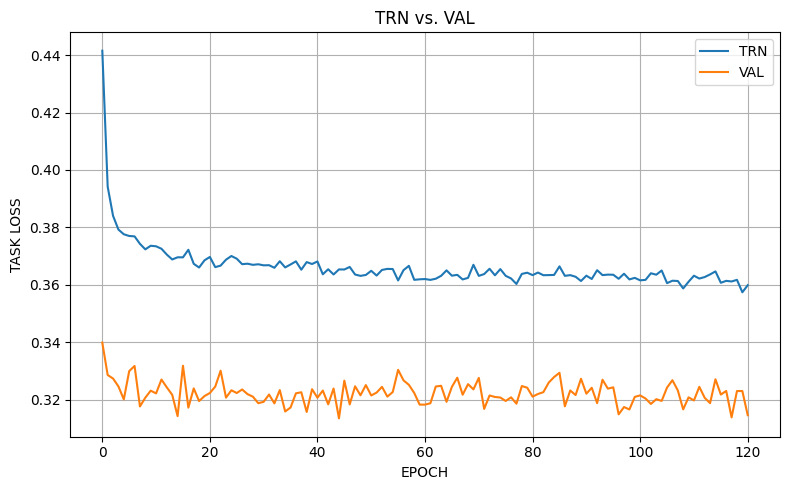

In [ ]:
UTILS.visualizer.loss_plot(history, 'TASK LOSS')

# Test

In [ ]:
kwargs = dict(
    model=model,
    dataloader=tst_loader,
)

result = predict(**kwargs)

TST: 100%|██████████| 2005/2005 [00:05<00:00, 392.88it/s]


In [ ]:
eval = top_k_loop(result)
eval

,top_k,hit_ratio,precision,recall,map,ndcg
0,5,0.737705,0.270492,0.224292,0.154166,0.326575
1,10,0.862295,0.213770,0.314257,0.183251,0.342671
2,15,0.914754,0.182951,0.379754,0.198208,0.359461
3,20,0.947541,0.161475,0.430633,0.207669,0.373180
4,50,0.996721,0.107836,0.611072,0.233481,0.429200
5,100,1.000000,0.072787,0.731352,0.245392,0.468714


# Save

In [ ]:
PATH = f'./_checkpoints/{LEARNING_TYPE}/{MODEL_NAME}.pth'

kwargs = dict(
    model=model,
    path=PATH,
)

UTILS.checkpointer.save(**kwargs)